In [3]:
!cd ../

In [3]:
#!pip install torchtext==0.4.0

In [1]:
# import packages
import os
import random
import math
import time

import numpy
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [2]:
# load data
path_do_data = '../../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

In [3]:
#!pip install torchtext==0.2.3

In [3]:
# The structure of the file: src_sentence \t trg_sentence
with open(path_do_data, encoding="utf-8") as file:
    for line in file:
        line = line
        print(line)
        break

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



In [4]:
test_src, test_trg = line.split("\t")
print(f"test_src: {test_src}")
print(f"test_trg: {test_trg}")

test_src: Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.
test_trg: Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



In [5]:
# make train, valid, test split
tokenizer_words = WordPunctTokenizer()
def tokenize(text):
    return tokenizer_words.tokenize(text.lower())
print(tokenize(test_src))
print(tokenize(test_trg))

['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']
['отель', 'cordelia', 'расположен', 'в', 'тбилиси', ',', 'в', '3', 'минутах', 'ходьбы', 'от', 'свято', '-', 'троицкого', 'собора', '.']


In [6]:
SRC = Field(tokenize=tokenize,
            init_token='<sos>',
            eos_token='<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token='<sos>',
            eos_token='<eos>',
            lower = True)

In [8]:
dataset = torchtext.data.TabularDataset(path=path_do_data,
                                     format="tsv",
                                     fields=[("trg", TRG), ("src", SRC)],
                                     )

In [9]:
train_data, test_data, valid_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 7500
Number of testing examples: 2500


In [11]:
test_example = vars(train_data.examples[0])
print(f"test_example src: {test_example['src']}")
print(f"test_example trg: {test_example['trg']}")

test_example src: ['познакомиться', 'с', 'регионом', 'ко', 'ланта', 'вам', 'поможет', 'экскурсионное', 'бюро', ',', 'где', 'можно', 'приобрести', 'билеты', 'и', 'воспользоваться', 'услугами', 'проката', 'автомобилей', '.']
test_example trg: ['exploring', 'koh', 'lanta', 'is', 'easy', 'with', 'a', 'tour', 'desk', 'that', 'offers', 'ticket', 'and', 'car', 'hire', 'services', '.']


In [12]:
# Build the vocab for src and trg

SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [13]:
print(f"The number of unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"The number of unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

The number of unique tokens in source (ru) vocabulary: 9252
The number of unique tokens in target (en) vocabulary: 6703


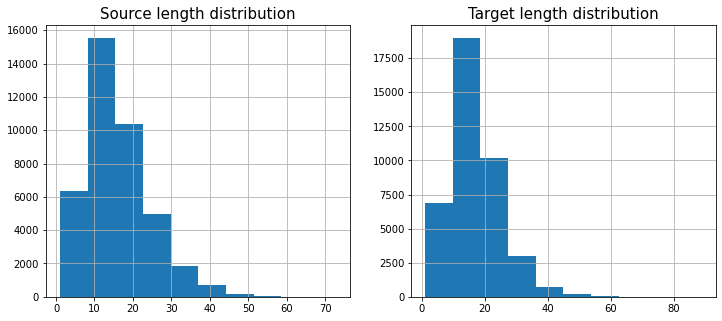

In [14]:
# length distribution
src_length = list(map(len, [vars(x)['src'] for x in train_data]))
trg_length = list(map(len, [vars(x)['trg'] for x in train_data]))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title("Source length distribution", size=15)
plt.hist(src_length);

plt.subplot(1, 2, 2)
plt.grid()
plt.title("Target length distribution", size=15)
plt.hist(trg_length);

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def _len_sort_key(x):
    return len(x.src)

batch_size=128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data),
                                                                batch_size = batch_size,
                                                                sort_key=_len_sort_key,
                                                                device=device)

In [16]:
for batch in train_iterator:
    (x, y), _ = batch
    break
print(x.shape)
print(y.shape)

torch.Size([45, 128])
torch.Size([49, 128])


In [18]:
src_tokens_num = len(SRC.vocab)
trg_tokens_num = len(TRG.vocab)

In [19]:
nn.Embedding(src_tokens_num, 16)(x).shape

torch.Size([55, 128, 16])

In [49]:
### test baseline model

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.p = dropout
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.dropout = nn.Dropout(p=self.p)
        
    def forward(self, src):      
        #src = [src_len, batch_size]
    
        embedded = self.embedding(src) 
        embedded = self.dropout(embedded)
        #embedded = [src_len, batch_size, emb_dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        #outputs = [src_len, batch size, hid_dim * n_directions]
        #hidden = [n_layers * n_directions, batch_size, hid_dim]
        #cell = [n_layers * n_directions, batch_size, hid_dim]
        
        return hidden, cell



class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(
            num_embeddings=self.output_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=self.hid_dim ,
            num_layers=self.n_layers,
            dropout=dropout
        )
         
        self.fc = nn.Linear(self.hid_dim, self.output_dim)
        
    def forward(self, input_, hidden, cell):
        # input_=[batch_size], hidden, cell=[num_layers*num_directions, batch_size, hid_size]
        input_ = input_.unsqueeze(0) # input_=[1, batch_size]
        embedding = self.embedding(input_)
        # embedding = [1, batch_size, emb_dim]
        output, (hidden, cell) = self.rnn(embedding)
        # output = [1, batch_size, hid_size], hidden,= [num_layers*num_directions, batch_size, hid_size]
        logits = self.fc(output.squeeze(0))
        # logits = [batch_size, trg_vocab_len]
        return logits, hidden, cell
    
enc = Encoder(src_tokens_num, 128, 64, 2, 0.15)
enc_out = enc(x)
print(enc_out[0].shape, enc_out[1].shape)
dec = Decoder(trg_tokens_num, 128, 64, 2, 0.15)
dec_out = dec(y[0], enc_out[0], enc_out[1])
dec_out[0].shape, dec_out[1].shape, dec_out[2].shape

torch.Size([2, 128, 64]) torch.Size([2, 128, 64])


(torch.Size([128, 6727]), torch.Size([2, 128, 64]), torch.Size([2, 128, 64]))

In [57]:
len(TRG.vocab)

6727

In [55]:
trg_tokens_num, src_tokens_num

(6727, 9244)

In [63]:
import random
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, teacher_forcing_ratio):
        super().__init__()
        
        self.enc = encoder
        self.dec = decoder
        self.teach_force_rat = teacher_forcing_ratio
        
    def forward(self, src, trg):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.dec.output_dim
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size)
        h_pred, c_pred = enc(src)
        
        input_ = trg[0, :] # first token is <sos>
        for t in range(1, max_len):
            #print(max(input_))
            dec_output_t, h_pred, c_pred = self.dec(input_, h_pred, c_pred)
            outputs[t] = dec_output_t
            teacher_force = random.random() < self.teach_force_rat
            top1 = dec_output_t.max(1)[1]
            input_ = (trg[t] if teacher_force else top1)
            
        return outputs
    
test_s = Seq2Seq(enc, dec, 0.5)
test_s(y, x).shape

torch.Size([55, 128, 6727])